##########################     
dsr分数调整

    1. 基于教材：
        ①72.5(60,85)中值与ename的median的差值来调整，   
       if 提整值如果超过[-11,11]的话，按照-11或11计算；     
       if 调整后的值如果查过[0,100]的话，按照0或100来计分    
       
        ②72.5(60,85)中值与ename的mean的差值来调整，
       if 提整值如果超过[-11,11]的话，按照-11或11计算；
       if 调整后的值如果查过[0,100]的话，按照0或100来计分
       
    2. 基于年龄
##########################

In [1]:
%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
from datetime import datetime
import re
import random

In [2]:
df_young = pd.read_csv('young.csv').drop(['Unnamed: 0','new_score','new_score_mean','new_score_mean_ts11'], axis=1)
df_young.head(2)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2


In [3]:
df_ename = df_young.groupby(by='ename').score.describe()
df_ename.head(3)

ename           
ABC Books  count    56.000000
           mean     48.232143
           std      32.009085
Name: score, dtype: float64

-------调节分数--------

① 72.5(60,85)中值与ename的median的差值来调整，    
if 提整值如果超过[-11,11]的话，按照-11或11计算；     
if 调整后的值如果查过[0,100]的话，按照0或100来计分    

In [4]:
# 以72.5与meadian的差值来调整
median_dict = df_ename.unstack()[['50%']].to_dict()['50%']
adjust_dict = {k:72.5-v for k, v in median_dict.items()}

# 设置调整的阈值上限
new_adj_dict = {}
for k,v in adjust_dict.items():
    if v < 0:
        new_adj_dict[k] = 0
    elif v > 11:
        new_adj_dict[k] = 10
    else:
        new_adj_dict[k] = v
score_adj = [df_young.score[i]+new_adj_dict[df_young.ename[i]] for i in range(len(df_young))]

In [5]:
# 调整后的数值可能大于100或小于0，让这些数据随机生成一个【90-100】或【0-10】之间的随机数
new_score = []
for i in range(len(score_adj)):
    if score_adj[i] > 100:
        new_score.append(random.randrange(90,100,1))
    elif score_adj[i] < 0:
        new_score.append(random.randrange(0,10,1))
    else:
        new_score.append(np.ceil(score_adj[i]))
df_young['score_median'] = new_score

In [6]:
# 划分后比例变化
df_star_ratio = pd.DataFrame()
df_star_ratio['ratio_old'] = [len(df_young[df_young.score < 60]) / len(df_young),
len(df_young[(df_young.score >= 60) & (df_young.score < 85)]) / len(df_young), 
len(df_young[df_young.score >= 85]) / len(df_young)]
df_star_ratio['ratio_median'] = [len(df_young[df_young.score_median < 60]) / len(df_young),
len(df_young[(df_young.score_median >= 60) & (df_young.score_median < 85)]) / len(df_young), 
len(df_young[df_young.score_median >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star', '2 stars', '3 stars']
df_star_ratio

,ratio_old,ratio_median
1 star,0.364525,0.313525
2 stars,0.388232,0.380030
3 stars,0.247244,0.306444


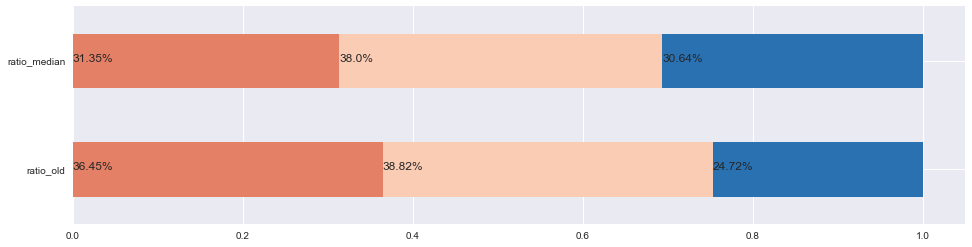

In [7]:
plt.rc('figure', figsize=(16,4))
df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                     color=[sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]])
for i in range(len(df_star_ratio.columns)):
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[0]*100,2))+"%",[0,i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[1]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0],i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[2]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0] + df_star_ratio.' + df_star_ratio.columns[i] +'.values[1],i])')

② 72.5(60,85)中值与ename的mean的差值来调整，     
if 提整值如果超过[-11,11]的话，按照-11或11计算；     
if 调整后的值如果查过[0,100]的话，按照0或100来计分     

In [8]:
# 以72.5与meadian的差值来调整
mean_dict = df_ename.unstack()[['mean']].to_dict()['mean']
adjust_dict = {k:72.5-v for k, v in mean_dict.items()}

# 设置调整的阈值上限
new_adj_dict = {}
for k,v in adjust_dict.items():
    if v < 0:
        new_adj_dict[k] = 0
    elif v > 11:
        new_adj_dict[k] = 10
    else:
        new_adj_dict[k] = v
score_adj = [df_young.score[i]+new_adj_dict[df_young.ename[i]] for i in range(len(df_young))]

In [9]:
# 调整后的数值可能大于100或小于0，让这些数据随机生成一个【90-100】或【0-10】之间的随机数
new_score = []
for i in range(len(score_adj)):
    if score_adj[i] > 100:
        new_score.append(random.randrange(90,100,1))
    elif score_adj[i] < 0:
        new_score.append(random.randrange(0,10,1))
    else:
        new_score.append(np.ceil(score_adj[i]))
df_young['score_mean'] = new_score

In [10]:
# 划分后比例变化
df_star_ratio['ratio_mean'] = [len(df_young[df_young.score_mean < 60]) / len(df_young),
len(df_young[(df_young.score_mean >= 60) & (df_young.score_mean < 85)]) / len(df_young), 
len(df_young[df_young.score_mean >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star', '2 stars', '3 stars']
df_star_ratio

,ratio_old,ratio_median,ratio_mean
1 star,0.364525,0.313525,0.282917
2 stars,0.388232,0.380030,0.357892
3 stars,0.247244,0.306444,0.359192


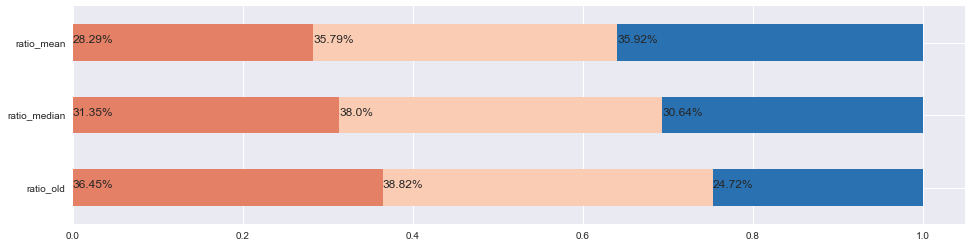

In [11]:
plt.rc('figure', figsize=(16,4))
df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                     color=[sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]])
for i in range(len(df_star_ratio.columns)):
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[0]*100,2))+"%",[0,i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[1]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0],i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[2]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0] + df_star_ratio.' + df_star_ratio.columns[i] +'.values[1],i])')

In [52]:
df_count = pd.DataFrame(df_young.ename.value_counts())
df_count.head(2)

,ename
GE2 (S_B),1551
GE1(S_A),1463


In [75]:
df_young = pd.merge(df_young,df_count,left_on='ename',right_index=True)
df_young = df_young.drop(['ename_x'], axis=1)
df_young = df_young.sort_values(by=['ename_y'],ascending=False)

df_young.columns =[u'ename', u'audio_quality', u'city_name', u'exercise_id', u'hyp_text',
       u'location', u'region_name', u'score', u'segments', u'timestamp',
       u'url', u'user_id', u'age', u'course_unit_id', u'course_id', u'pspt_id',
       u'birth_dt', u'star', u'score_median', u'score_mean', u'median_star',
       u'mean_star', u'ename_count']

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

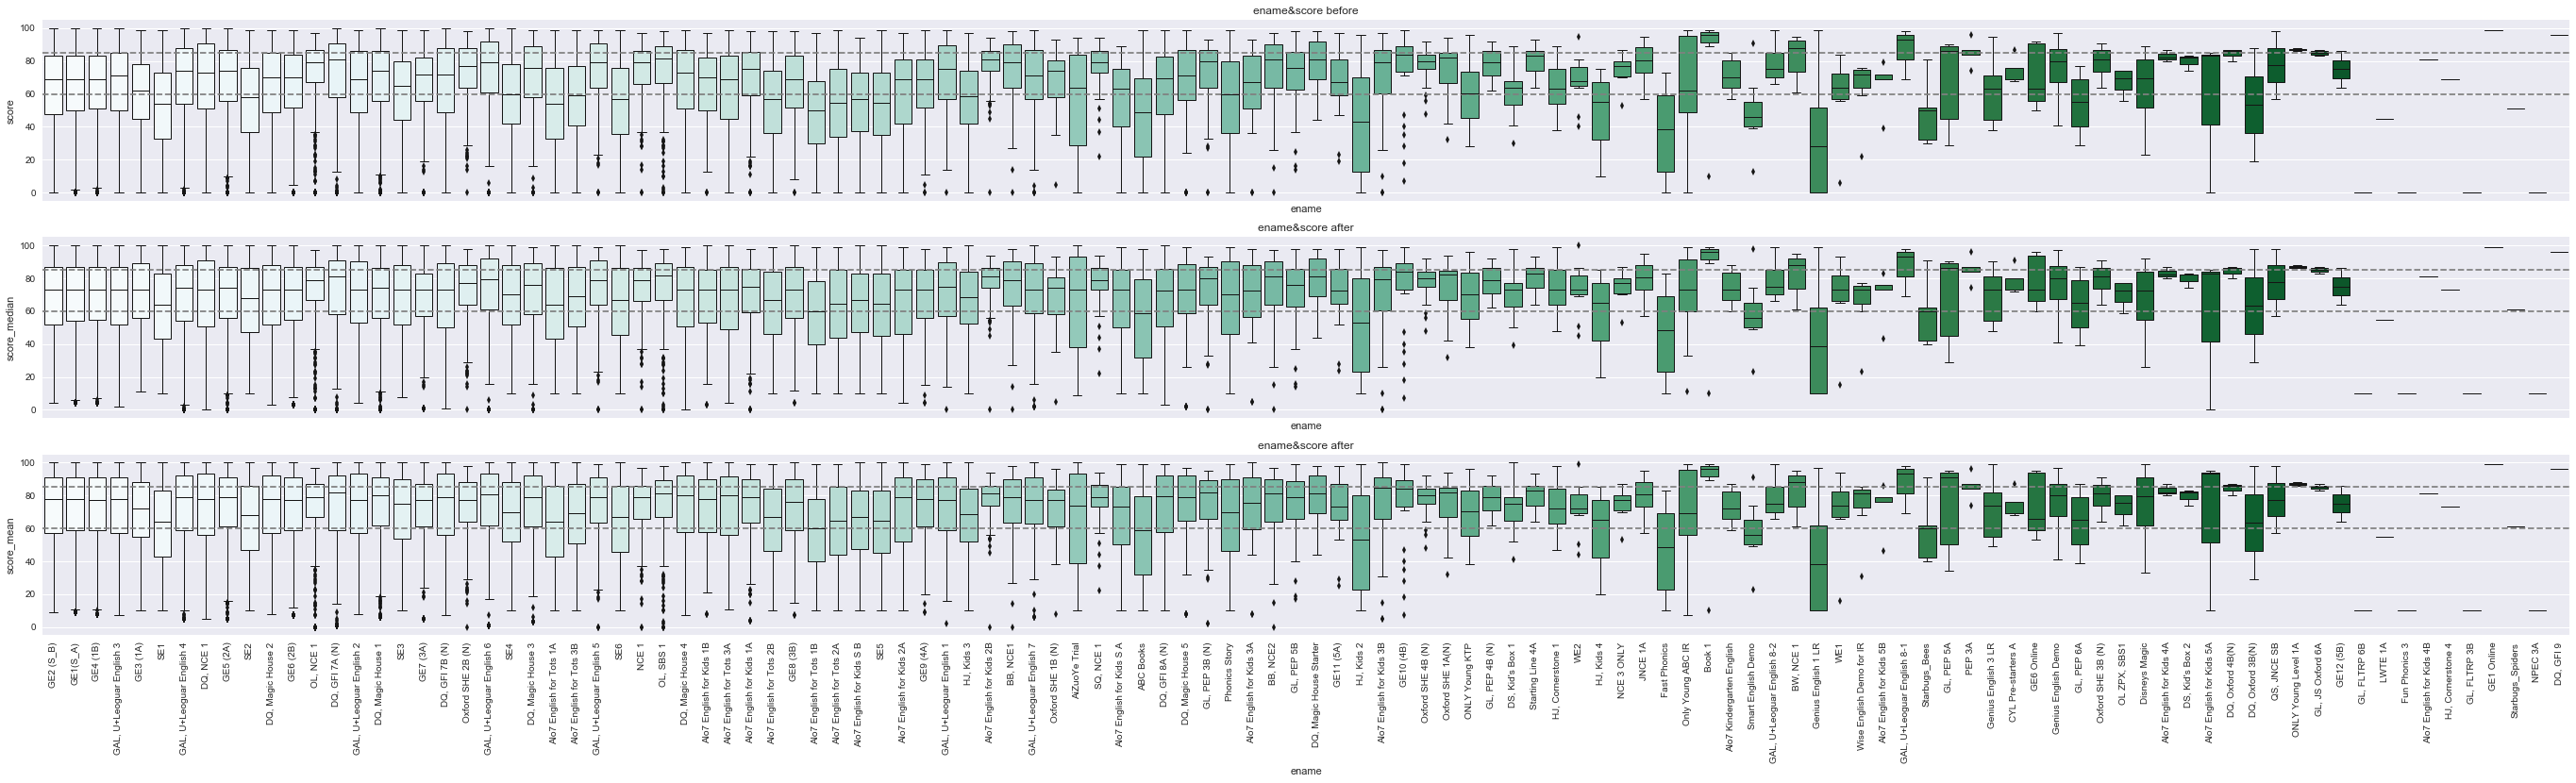

In [90]:
# 划分前后教材的分数分布
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(48, 12), sharex=True)

sns.boxplot(x="ename", y="score", data=df_young, palette='BuGn',linewidth=1, ax=ax1)
ax1.axhline(60, linestyle='--', color='grey')
ax1.axhline(85, linestyle='--', color='grey')
ax1.set_title('ename&score before')

sns.boxplot(x="ename", y="score_median", data=df_young, palette='BuGn',linewidth=1, ax=ax2)
ax2.axhline(60, linestyle='--', color='grey')
ax2.axhline(85, linestyle='--', color='grey')
ax2.set_title('ename&score after')

sns.boxplot(x="ename", y="score_mean", data=df_young, palette='BuGn',linewidth=1, ax=ax3)
ax3.axhline(60, linestyle='--', color='grey')
ax3.axhline(85, linestyle='--', color='grey')
ax3.set_title('ename&score after')

plt.xticks(rotation=90)

In [14]:
# 查看出现星级变化的record

In [15]:
median_star = []
for score in df_young.score_median.values:
    if score < 60:
        median_star.append(1)
    elif (score >= 60)&(score < 85):
        median_star.append(2)
    else:
        median_star.append(3)
df_young['median_star'] = median_star

In [16]:
mean_star = []
for score in df_young.score_mean.values:
    if score < 60:
        mean_star.append(1)
    elif (score >= 60)&(score < 85):
        mean_star.append(2)
    else:
        mean_star.append(3)
df_young['mean_star'] = mean_star

In [145]:
df_young.head(1)

,ename,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,pspt_id,birth_dt,star,score_median,score_mean,median_star,mean_star,ename_count
0,GE2 (S_B),ok,Beijing,615874,THIS IS A SWING,"{u'lat': 39.9289, u'lon': 116.3883}",Beijing,77,"[{u'status': u'ok', u'begin': 210, u'end': 780...",2018-06-10T04:31:08.529Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,19188966,7,13371,1203,19188966,2011-10-22 00:00:00,2,81.0,86.0,2,3,1551


In [146]:
len(df_young)

22314

In [179]:
# 过滤掉做题记录不多的题目
df_sample = df_young.iloc[:20803]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

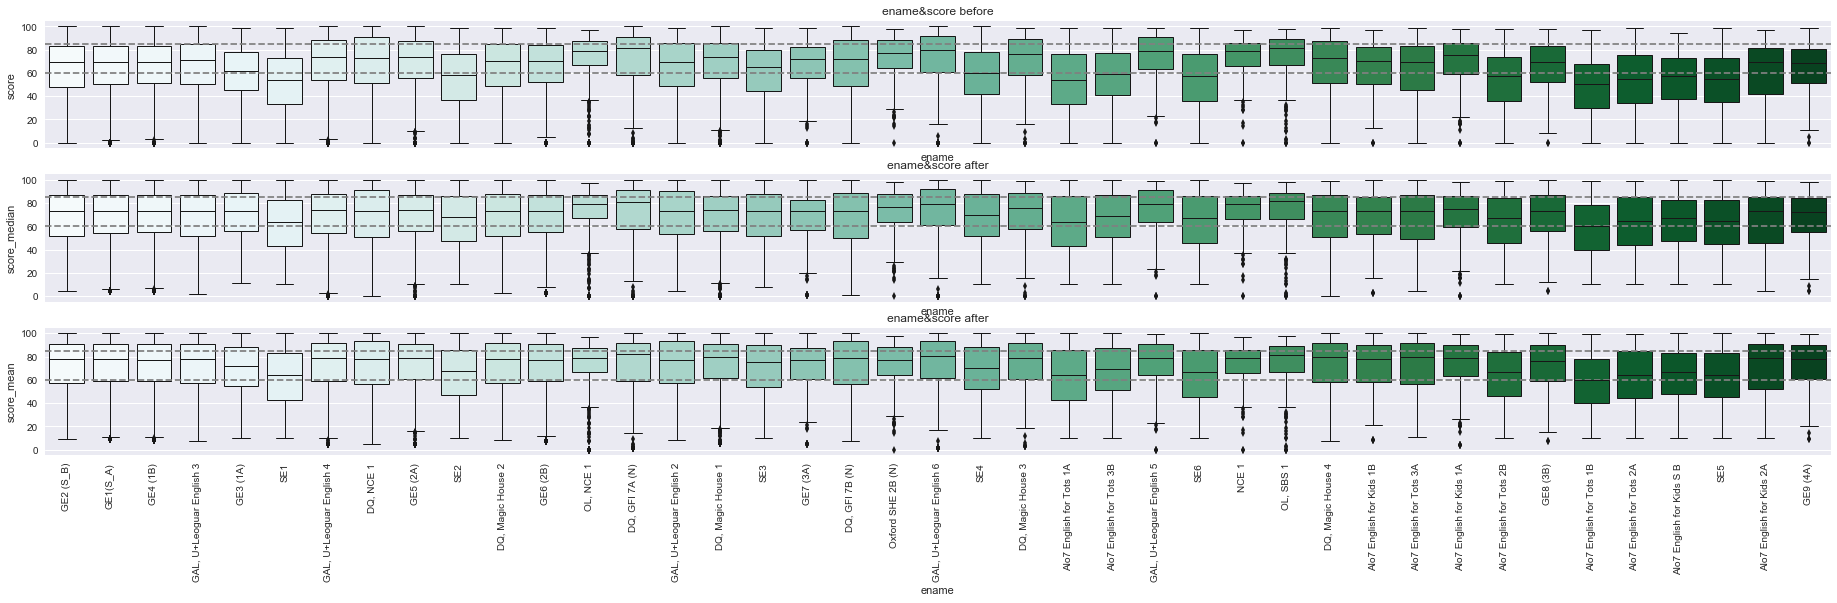

In [190]:
# 常用教材
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(32,8), sharex=True)

sns.boxplot(x="ename", y="score", data=df_sample, palette='BuGn',linewidth=1, ax=ax1)
ax1.axhline(60, linestyle='--', color='grey')
ax1.axhline(85, linestyle='--', color='grey')
ax1.set_title('ename&score before')

sns.boxplot(x="ename", y="score_median", data=df_sample, palette='BuGn',linewidth=1, ax=ax2)
ax2.axhline(60, linestyle='--', color='grey')
ax2.axhline(85, linestyle='--', color='grey')
ax2.set_title('ename&score after')

sns.boxplot(x="ename", y="score_mean", data=df_sample, palette='BuGn',linewidth=1, ax=ax3)
ax3.axhline(60, linestyle='--', color='grey')
ax3.axhline(85, linestyle='--', color='grey')
ax3.set_title('ename&score after')

plt.xticks(rotation=90)

In [194]:
df_sample['adjust_median'] = df_sample.score_median - df_sample.score
df_sample['adjust_mean'] = df_sample.score_mean - df_sample.score

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


这个方式，一定程度上能调节各星级的比例，基于这样的评分方式后，相当于每本教材的分值松紧度会改变。因此带来的问题：

1. 难教材的75分与容易教材的75分，我们知道实际上难教材75分的学生能力更好，但实际从家长的角度会觉得产生了误判————产品可以提供一些小贴士
2. 分数虽然有提升，但每本教材内部可能存在，确实读的不好，原来是1星，经过调整后成为了3星级
1星升2星不合理的（很多）：   
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/10/04/41887519/672785/b2556c78f2ca8a6b586bc46c7c5783c3.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/71783037/672839/7283fe095e8df85b35d91a0893ecbc49.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/71783037/672784/ec306196dab44cd278e52fac5f6d7cc0.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/13/05/53318101/803991/1d9de8bd123b462413feb942779dd113.wav        
2星升3星不合理的(很多)：     
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/71783037/674251/8435bf83a4d0aeebea96aaf88a2af0c7.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/71783037/674253/06f3fc837ea1d3b066da9e8f9ccc8260.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/10/04/82315598/672791/f836579aeeb70c46843d0b2dce42f15c.wav
https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/13/04/27040447/599140/869a70b4722be725682fc7195aab0a1c.wav

### 基于年级来调整分数

In [279]:
df_age_diff = pd.DataFrame([[5,6,7,8,9,10,11,12,13,14,15]]).T
df_age_diff.columns = ['age']
df_age_diff['difficulty'] = pd.Series([862,885,894,928,949,976,994,1031,1063,1072,1095])

In [281]:
df_age_diff

,age,difficulty
0,5,862
1,6,885
2,7,894
3,8,928
4,9,949
5,10,976
6,11,994
7,12,1031
8,13,1063
9,14,1072


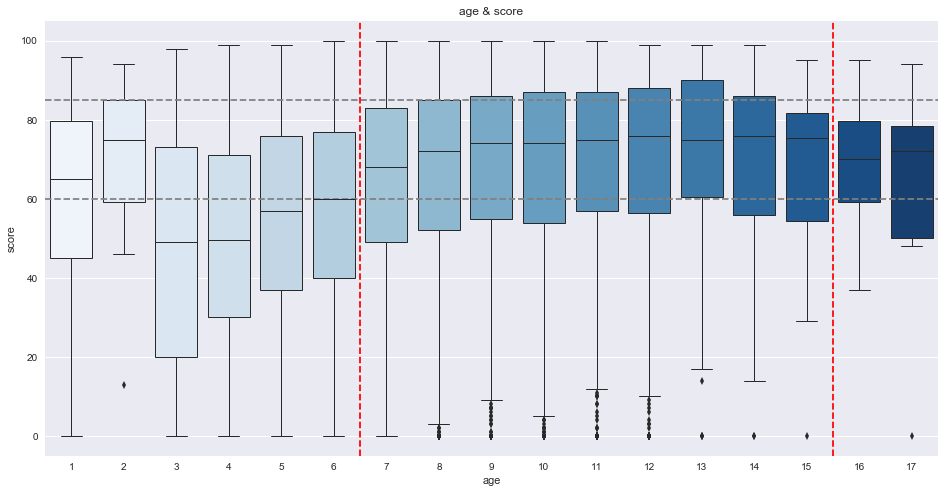

In [244]:
plt.rc('figure', figsize=(16, 8))
sns.boxplot(x="age", y="score", data=df_young, palette=sns.color_palette("Blues",17),linewidth=1)
plt.axhline(60, linestyle='--', color='grey')
plt.axhline(85, linestyle='--', color='grey')
plt.axvline(5.5, linestyle='--', color='red')
plt.axvline(14.5, linestyle='--', color='red')
plt.title("age & score")

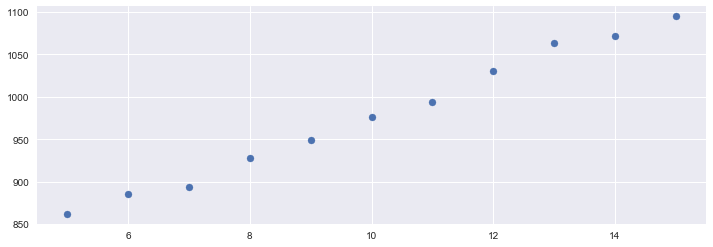

In [295]:
plt.rc('figure', figsize=(12, 4))
plt.scatter(df_age_diff.age.values,df_age_diff.difficulty.values)

In [314]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model

In [309]:
y = df_age_diff.difficulty.values
x = df_age_diff.age.values
res = sm.OLS(x, y).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     185.8
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           8.74e-08
Time:                        16:35:17   Log-Likelihood:                -25.101
No. Observations:                  11   AIC:                             52.20
Df Residuals:                      10   BIC:                             52.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0104      0.001     13.631      0.0

In [302]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('Predicted values: ', res.predict())

('Parameters: ', array([ 91.0421]))
('Standard errors: ', array([ 6.6789]))
('Predicted values: ', array([  455.2107,   546.2529,   637.295 ,   728.3372,   819.3793,
         910.4215,  1001.4636,  1092.5058,  1183.5479,  1274.5901,
        1365.6322]))


使用sklearn

In [328]:
reg = linear_model.LinearRegression()
reg.fit(x.reshape(-1,1), y.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [329]:
print reg.coef_
print reg.intercept_

[[ 24.2818]]
[ 734.3636]


array([ 734.3636])